# GUJARAT RAINFALL TREND ANALYSIS

Mounting Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### INSTALLING NECESSARY LIBRARIES

In [2]:
!pip install geopandas

In [3]:
!pip install tslearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 369.8/369.8 kB 6.8 MB/s eta 0:00:00


In [4]:
!pip install fastdtw

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=512574 sha256=7ccf139ecebbfce1f279bedaca6439c442d87bc2e0e8597eb3171b0581fbd57e
  Stored in directory: /root/.cache/pip/wheels/73/c8/f7/c25448dab74c3acf4848bc25d513c736bb93910277e1528ef4
Successfully built fastdtw


In [5]:
!pip install pymannkendall

In [6]:
!pip install pyhomogeneity

In [7]:
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

import pyproj
from shapely.geometry import Point

import pandas as pd

from fastdtw import fastdtw

from scipy.stats import kendalltau, norm, linregress

import pyhomogeneity as hg

### IMPLEMENTATION

IMPORTING INDIAN METEROLOGICAL DEPARTMENT (IMD) RAINFALL DATASETS 2022 TO 1901

In [8]:
data_path = '/content/drive/MyDrive/ColabNotebooks/IMD-RAINFALL-DATASET/Rainfall-dataset-2022to1901/'

In [9]:
rainfall_data_2022 = xr.open_dataset(data_path + '2022.nc')
print(rainfall_data_2022.head())

<xarray.Dataset>
Dimensions:    (LONGITUDE: 5, LATITUDE: 5, TIME: 5)
Coordinates:
  * LONGITUDE  (LONGITUDE) float64 66.5 67.5 68.5 69.5 70.5
  * LATITUDE   (LATITUDE) float64 6.5 7.5 8.5 9.5 10.5
  * TIME       (TIME) datetime64[ns] 2022-01-01 2022-01-02 ... 2022-01-05
Data variables:
    RAINFALL   (TIME, LATITUDE, LONGITUDE) float64 ...
Attributes:
    history:      FERRET V7.5 (optimized) 19-Jan-23
    Conventions:  CF-1.6


PRINTING THE LATITUDNAL AND LONGITUDNAL RANGE OF THE RAINFALL DATASETS

In [10]:
# Access the longitude and latitude coordinates from the dataset
longitude_values = rainfall_data_2022['LONGITUDE'].values
latitude_values = rainfall_data_2022['LATITUDE'].values

# Find the minimum and maximum values for longitude and latitude
min_longitude = longitude_values.min()
max_longitude = longitude_values.max()
min_latitude = latitude_values.min()
max_latitude = latitude_values.max()

# Print the range of longitude and latitude
print(f"Longitude Range: ({min_longitude}, {max_longitude})")
print(f"Latitude Range: ({min_latitude}, {max_latitude})")

Longitude Range: (66.5, 100.5)
Latitude Range: (6.5, 38.5)


In [11]:
print(f"Latitude values: {latitude_values}", "\n")

print(f"Longitude values: {longitude_values}")

Latitude values: [ 6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5 14.5 15.5 16.5 17.5 18.5 19.5
 20.5 21.5 22.5 23.5 24.5 25.5 26.5 27.5 28.5 29.5 30.5 31.5 32.5 33.5
 34.5 35.5 36.5 37.5 38.5] 

Longitude values: [ 66.5  67.5  68.5  69.5  70.5  71.5  72.5  73.5  74.5  75.5  76.5  77.5
  78.5  79.5  80.5  81.5  82.5  83.5  84.5  85.5  86.5  87.5  88.5  89.5
  90.5  91.5  92.5  93.5  94.5  95.5  96.5  97.5  98.5  99.5 100.5]


IMPORTING THE SHAPEFILE OF INDIA

In [12]:
India_shapefile_path = '/content/drive/MyDrive/ColabNotebooks/IMD-RAINFALL-DATASET/SHAPEFILENEW/india_district.shp'
India_shapefile = gpd.read_file(India_shapefile_path)
print(India_shapefile)

     censuscode    district  dt_cen_cd  st_cen_cd           st_nm  \
0         536.0   Hyderabad          5         28  Andhra Pradesh   
1         494.0         Diu          1         25     Daman & Diu   
2          91.0       North          2          7    NCT of Delhi   
3         191.0    AZAMGARH         61          9   Uttar Pradesh   
4           NaN       HAPUR         73          9   Uttar Pradesh   
..          ...         ...        ...        ...             ...   
640       146.0        AGRA         15          9   Uttar Pradesh   
641       166.0      JHANSI         36          9   Uttar Pradesh   
642       167.0    LALITPUR         37          9   Uttar Pradesh   
643       171.0  CHITRAKOOT         41          9   Uttar Pradesh   
644       199.0    MIRZAPUR         69          9   Uttar Pradesh   

                                              geometry  
0    POLYGON ((78.51164 17.45434, 78.54018 17.46267...  
1                                                 None  


In [13]:
print(India_shapefile['st_nm'].unique())

['Andhra Pradesh' 'Daman & Diu' 'NCT of Delhi' 'Uttar Pradesh'
 'West Bengal' 'Assam' 'Jharkhand' 'Puducherry' 'Tamil Nadu'
 'Jammu & Kashmir' 'Haryana' 'Odisha' 'Bihar' 'Nagaland'
 'Himachal Pradesh' 'Manipur' 'Maharashtra' 'Kerala' 'Madhya Pradesh'
 'Punjab' 'Rajasthan' 'Sikkim' 'Karnataka' 'Chhattisgarh' 'Gujarat'
 'Uttarakhand' 'Mizoram' 'Goa' 'Meghalaya' 'Arunanchal Pradesh'
 'Chandigarh' 'Tripura' 'Andaman & Nicobar Island' 'Lakshadweep'
 'Dadara & Nagar Havelli']






FILTERING WEST BENGAL'S GEODATAFRAME FROM THE SHAPEFILE OF INDIA

In [14]:
# Filter the GeoDataFrame to get the gujarat polygon
gujarat_shapefile = India_shapefile[India_shapefile['st_nm'] == 'Gujarat']
print(gujarat_shapefile)

     censuscode       district  dt_cen_cd  st_cen_cd    st_nm  \
56        478.0      Porbandar         11         24  Gujarat   
135       482.0          Anand         15         24  Gujarat   
140       491.0         Valsad         24         24  Gujarat   
147       474.0      Ahmadabad          7         24  Gujarat   
156       468.0        Kachchh          1         24  Gujarat   
222       471.0       Mahesana          4         24  Gujarat   
229       484.0   Panch Mahals         17         24  Gujarat   
244       492.0          Surat         25         24  Gujarat   
245       475.0  Surendranagar          8         24  Gujarat   
271       486.0       Vadodara         19         24  Gujarat   
292       493.0           Tapi         26         24  Gujarat   
319       470.0          Patan          3         24  Gujarat   
337       469.0   Banas Kantha          2         24  Gujarat   
366       477.0       Jamnagar         10         24  Gujarat   
380       479.0       Jun

PRINTING THE LATITUDNAL AND LONGITUDNAL RANGE OF WEST BENGAL

In [15]:
# Extract the geometry of the gujarat polygon
gujarat_geometry = gujarat_shapefile['geometry'].iloc[0]

# Get the bounding box (envelope) of the gujarat polygon
gujarat_bbox = gujarat_geometry.bounds

# Extract latitude and longitude range
min_longitude, min_latitude, max_longitude, max_latitude = gujarat_bbox

print(f"Latitude Range: {min_latitude} to {max_latitude}")
print(f"Longitude Range: {min_longitude} to {max_longitude}")


Latitude Range: 21.226805 to 21.974347
Longitude Range: 69.374033 to 70.147947


In [16]:
min_longitude, min_latitude, max_longitude, max_latitude = 68.16694444,20.10027778,74.46694444,24.70027778

print(f"Latitude Range: {min_latitude} to {max_latitude}")
print(f"Longitude Range: {min_longitude} to {max_longitude}")

Latitude Range: 20.10027778 to 24.70027778
Longitude Range: 68.16694444 to 74.46694444


AVERAGE DAILY RAINFALL OF GUJARAT FROM 2022 TO 1901

In [17]:
for year in range(2022, 1900, -1):
  rainfall_data = xr.open_dataset(data_path + f'{year}.nc')
  # Find latitude and longitude indices within the gujarat's boundaries
  latitude_indices = np.where((rainfall_data['LATITUDE'] >= min_latitude) & (rainfall_data['LATITUDE'] <= max_latitude))[0]
  longitude_indices = np.where((rainfall_data['LONGITUDE'] >= min_longitude) & (rainfall_data['LONGITUDE'] <= max_longitude))[0]

  # Slice the rainfall data for gujarat
  gujarat_rainfall_data = rainfall_data['RAINFALL'][:, latitude_indices, longitude_indices]
  #Calculate the average and sum rainfall for each day over the entire time range
  average_rainfall_per_day = np.mean(gujarat_rainfall_data, axis=(1, 2))
  sum_rainfall_per_day = np.sum(gujarat_rainfall_data, axis=(1, 2))
  # Plot the average rainfall for each day using a line plot
  plt.figure(figsize=(12, 6))
  plt.plot(np.arange(1, len(average_rainfall_per_day) + 1),average_rainfall_per_day , marker='o', linestyle='-', color='b')
  plt.xlabel('Day of the Year')
  plt.ylabel('Average Rainfall (mm)')
  plt.title(f'Average Daily Rainfall in gujarat for {year}')
  plt.grid(True)
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

SUM DAILY RAINFALL OF GUJARAT FROM 2022 TO 1901

In [18]:
for year in range(2022, 1900, -1):
  rainfall_data = xr.open_dataset(data_path + f'{year}.nc')
  # Find latitude and longitude indices within the gujarat's boundaries
  latitude_indices = np.where((rainfall_data['LATITUDE'] >= min_latitude) & (rainfall_data['LATITUDE'] <= max_latitude))[0]
  longitude_indices = np.where((rainfall_data['LONGITUDE'] >= min_longitude) & (rainfall_data['LONGITUDE'] <= max_longitude))[0]

  # Slice the rainfall data for gujarat
  gujarat_rainfall_data = rainfall_data['RAINFALL'][:, latitude_indices, longitude_indices]
  #Calculate the average and sum rainfall for each day over the entire time range
  average_rainfall_per_day = np.mean(gujarat_rainfall_data, axis=(1, 2))
  sum_rainfall_per_day = np.sum(gujarat_rainfall_data, axis=(1, 2))
  # Plot the sum rainfall for each day using a line plot
  plt.figure(figsize=(12, 6))
  plt.plot(np.arange(1, len(sum_rainfall_per_day) + 1),sum_rainfall_per_day , marker='o', linestyle='-', color='b')
  plt.xlabel('Day of the Year')
  plt.ylabel('Sum Rainfall (mm)')
  plt.title(f'Sum Daily Rainfall in gujarat for {year}')
  plt.grid(True)
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

 MONTHLY RAINFALL OF GUJARAT FROM 2022 TO 1901 (Using average daily rainfall)

In [19]:
for year in range(2022, 1900, -1):
    # Load the rainfall data for the current year
    rainfall_data = xr.open_dataset(data_path + f'{year}.nc')

    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    # Find latitude and longitude indices within the gujarat's boundaries
    latitude_indices = np.where((rainfall_data['LATITUDE'] >= min_latitude) & (rainfall_data['LATITUDE'] <= max_latitude))[0]
    longitude_indices = np.where((rainfall_data['LONGITUDE'] >= min_longitude) & (rainfall_data['LONGITUDE'] <= max_longitude))[0]

    # Slice the rainfall data for gujarat
    gujarat_rainfall_data = rainfall_data['RAINFALL'][:, latitude_indices, longitude_indices]
    average_rainfall_per_day = np.mean(gujarat_rainfall_data, axis=(1, 2))
    # Resample the data to monthly rainfall
    gujarat_monthly_rainfall = average_rainfall_per_day.resample(TIME='1M').sum()

    y_data = gujarat_monthly_rainfall.values.squeeze()

    # Plot the monthly rainfall using a line plot
    plt.figure(figsize=(12, 6))
    plt.plot(months, y_data, marker='o', linestyle='-', color='b')
    plt.xlabel('Month')
    plt.ylabel('Rainfall (mm)')
    plt.title(f'Monthly Rainfall in gujarat for {year}')
    plt.grid(True)
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

AVERAGE MONTHLY RAINFALL OF GUJARAT FROM 2022 TO 1901 (Using average daily rainfall)

In [20]:
for year in range(2022, 1900, -1):
    # Load the rainfall data for the current year
    rainfall_data = xr.open_dataset(data_path + f'{year}.nc')

    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    # Find latitude and longitude indices within the gujarat's boundaries
    latitude_indices = np.where((rainfall_data['LATITUDE'] >= min_latitude) & (rainfall_data['LATITUDE'] <= max_latitude))[0]
    longitude_indices = np.where((rainfall_data['LONGITUDE'] >= min_longitude) & (rainfall_data['LONGITUDE'] <= max_longitude))[0]

    # Slice the rainfall data for gujarat
    gujarat_rainfall_data = rainfall_data['RAINFALL'][:, latitude_indices, longitude_indices]
    average_rainfall_per_day = np.mean(gujarat_rainfall_data, axis=(1, 2))
    # Resample the data to monthly averages
    gujarat_monthly_average_rainfall = average_rainfall_per_day.resample(TIME='1M').mean()

    y_data = gujarat_monthly_average_rainfall.values.squeeze()

    # Plot the average monthly rainfall using a line plot
    plt.figure(figsize=(12, 6))
    plt.plot(months, y_data, marker='o', linestyle='-', color='b')
    plt.xlabel('Month')
    plt.ylabel('Average Rainfall (mm)')
    plt.title(f'Average Monthly Rainfall in Gujarat for {year}')
    plt.grid(True)
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

 DYNAMIC TIME WARPING (DTW) FOR ANALYSING THE SIMILARITY OF MONTHLY AVERAGE RAINFALL FROM 2022 TO 1901.
 ##### Lowest peaks : Highest similarity (vice versa)

In [21]:
for year1 in range(2022,1900,-1):
  dfs = []
  # Load the rainfall data for the current years
  rainfall_data1 = xr.open_dataset(data_path + f'{year1}.nc')

  # Find latitude and longitude indices within the gujarat's boundaries
  latitude_indices1 = np.where((rainfall_data1['LATITUDE'] >= min_latitude) & (rainfall_data1['LATITUDE'] <= max_latitude))[0]
  longitude_indices1 = np.where((rainfall_data1['LONGITUDE'] >= min_longitude) & (rainfall_data1['LONGITUDE'] <= max_longitude))[0]

  # Slice the rainfall data for gujarat
  gujarat_rainfall_data1 = rainfall_data1['RAINFALL'][:, latitude_indices1, longitude_indices1]
  average_rainfall_per_day1 = np.mean(gujarat_rainfall_data1, axis=(1, 2))
  # Resample the data to monthly averages
  gujarat_monthly_average_rainfall1 = average_rainfall_per_day1.resample(TIME='1M').mean()

  for year2 in range(year1-1,1900,-1):

    # Load the rainfall data for the current years
    rainfall_data2 = xr.open_dataset(data_path + f'{year2}.nc')

    # Find latitude and longitude indices within the gujarat's boundaries
    latitude_indices2 = np.where((rainfall_data2['LATITUDE'] >= min_latitude) & (rainfall_data2['LATITUDE'] <= max_latitude))[0]
    longitude_indices2 = np.where((rainfall_data2['LONGITUDE'] >= min_longitude) & (rainfall_data2['LONGITUDE'] <= max_longitude))[0]

    # Slice the rainfall data for gujarat
    gujarat_rainfall_data2 = rainfall_data2['RAINFALL'][:, latitude_indices2, longitude_indices2]
    average_rainfall_per_day2 = np.mean(gujarat_rainfall_data2, axis=(1, 2))
    # Resample the data to monthly averages
    gujarat_monthly_average_rainfall2 = average_rainfall_per_day2.resample(TIME='1M').mean()

    dtw_distance, _ = fastdtw(gujarat_monthly_average_rainfall1, gujarat_monthly_average_rainfall2)

    # Store the DTW distance and the corresponding year
    dfs.append({'Year': year2, 'DTW Distance': dtw_distance})

    # Create a DataFrame from the list of dictionaries
    result_df = pd.DataFrame(dfs)

  # Plot the DTW distances
  plt.figure(figsize=(40, 6))
  plt.plot(result_df['Year'], result_df['DTW Distance'], marker='o', linestyle='-', color='b')
  plt.xlabel('Years')
  plt.ylabel('DTW Distance')
  plt.title(f'Similarity of Gujarat\'s Average Monthly Rainfall of {year1} ')
  plt.xticks(np.arange(min(result_df['Year']), max(result_df['Year']) + 1, 1), rotation=45, ha='right')
  plt.grid(True)
  plt.show()


Output hidden; open in https://colab.research.google.com to view.

MONTHLY RAINFALL & TOTAL ANNUAL RAINFALL FROM 1901 TO 2022

In [22]:
dfs = []

for year in range(1901, 2023):
    # Load the rainfall data for the current year
    rainfall_data = xr.open_dataset(data_path + f'{year}.nc')

    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    # Find latitude and longitude indices within the state's boundaries
    latitude_indices = np.where((rainfall_data['LATITUDE'] >= min_latitude) & (rainfall_data['LATITUDE'] <= max_latitude))[0]
    longitude_indices = np.where((rainfall_data['LONGITUDE'] >= min_longitude) & (rainfall_data['LONGITUDE'] <= max_longitude))[0]

    # Slice the rainfall data for the state
    gujarat_rainfall_data = rainfall_data['RAINFALL'][:, latitude_indices, longitude_indices]

    # Resample the data to monthly averages

    average_rainfall_per_day = np.mean(gujarat_rainfall_data, axis=(1, 2))
    gujarat_monthly_rainfall = average_rainfall_per_day.resample(TIME='1M').sum()
    df_year = pd.DataFrame({
        'Year': [year] * len(gujarat_monthly_rainfall['TIME']),
        'Month': gujarat_monthly_rainfall['TIME'].dt.strftime('%b'),
        'Monthly Rainfall': gujarat_monthly_rainfall.values.flatten()
    })

    # Append the DataFrame to the list
    dfs.append(df_year)

# Concatenate all DataFrames into a single DataFrame
result_df = pd.concat(dfs, ignore_index=True)

# Pivot the DataFrame to have months as columns
result_df_pivoted = result_df.pivot_table(index='Year', columns='Month', values='Monthly Rainfall', aggfunc='sum', fill_value=0)

# Add a column for Total Annual Rainfall
result_df_pivoted['Total Annual Rainfall'] = result_df_pivoted.sum(axis=1)

# Reset index to make 'Year' a column again
result_df_pivoted = result_df_pivoted.reset_index()

# Display the resulting DataFrame
print(result_df_pivoted)

Month  Year       Apr         Aug        Dec       Feb       Jan         Jul  \
0      1901  0.788043  126.177574   0.114805  0.014304  3.022888  167.247637   
1      1902  0.604320  231.970203   8.667690  0.000000  1.554451  193.611008   
2      1903  0.000000  147.953519   0.000000  0.253611  0.450026  416.989702   
3      1904  0.074754   48.910271   0.582870  8.365556  1.201715  159.728111   
4      1905  0.196199   27.857644   0.057606  1.144431  0.243827  422.394710   
..      ...       ...         ...        ...       ...       ...         ...   
117    2018  0.067744  102.560117   0.000000  0.003855  0.000000  306.984822   
118    2019  0.465495  383.497564   1.383343  0.678197  0.014567  180.921293   
119    2020  6.272604  638.892573   7.572529  0.000000  0.227156  300.746002   
120    2021  1.963049   59.663558  13.108485  0.043745  1.003101  155.221893   
121    2022  0.025745  238.628595   0.182489  0.000000  1.242886  411.323676   

Month         Jun        Mar        May

In [23]:
mean = np.mean(result_df_pivoted['Total Annual Rainfall'] )
std = np.std(result_df_pivoted['Total Annual Rainfall'] )
print(f"Mean of Total Annual Rainfall: {mean} mm")
print(f"Standard deviation of Total Annual Rainfall: {std} mm")
print(f"Range of Total Annual Rainfall: {mean - std}mm <= Rainfall <= {mean + std}mm")
print('\n')
max_rainfall_year = result_df_pivoted.loc[result_df_pivoted['Total Annual Rainfall'].idxmax(), 'Year']
max_rainfall_value = result_df_pivoted['Total Annual Rainfall'].max()

print(f"Year with the Highest Rainfall: {max_rainfall_year}")
print(f"Highest Rainfall Value: {max_rainfall_value} mm")
print('\n')
min_rainfall_year = result_df_pivoted.loc[result_df_pivoted['Total Annual Rainfall'].idxmin(), 'Year']
min_rainfall_value = result_df_pivoted['Total Annual Rainfall'].min()

print(f"Year with the Lowest Rainfall: {min_rainfall_year}")
print(f"Lowest Rainfall Value: {min_rainfall_value} mm")

Mean of Total Annual Rainfall: 719.2067830596227 mm
Standard deviation of Total Annual Rainfall: 278.12480299411186 mm
Range of Total Annual Rainfall: 441.08198006551083mm <= Rainfall <= 997.3315860537346mm


Year with the Highest Rainfall: 2020
Highest Rainfall Value: 1338.1307052542957 mm


Year with the Lowest Rainfall: 2002
Lowest Rainfall Value: -1128.2997556847454 mm


In [24]:
from scipy.stats import zscore

TOTAL ANNUAL RAINFALL ANALYSIS FROM 1901 TO 2022

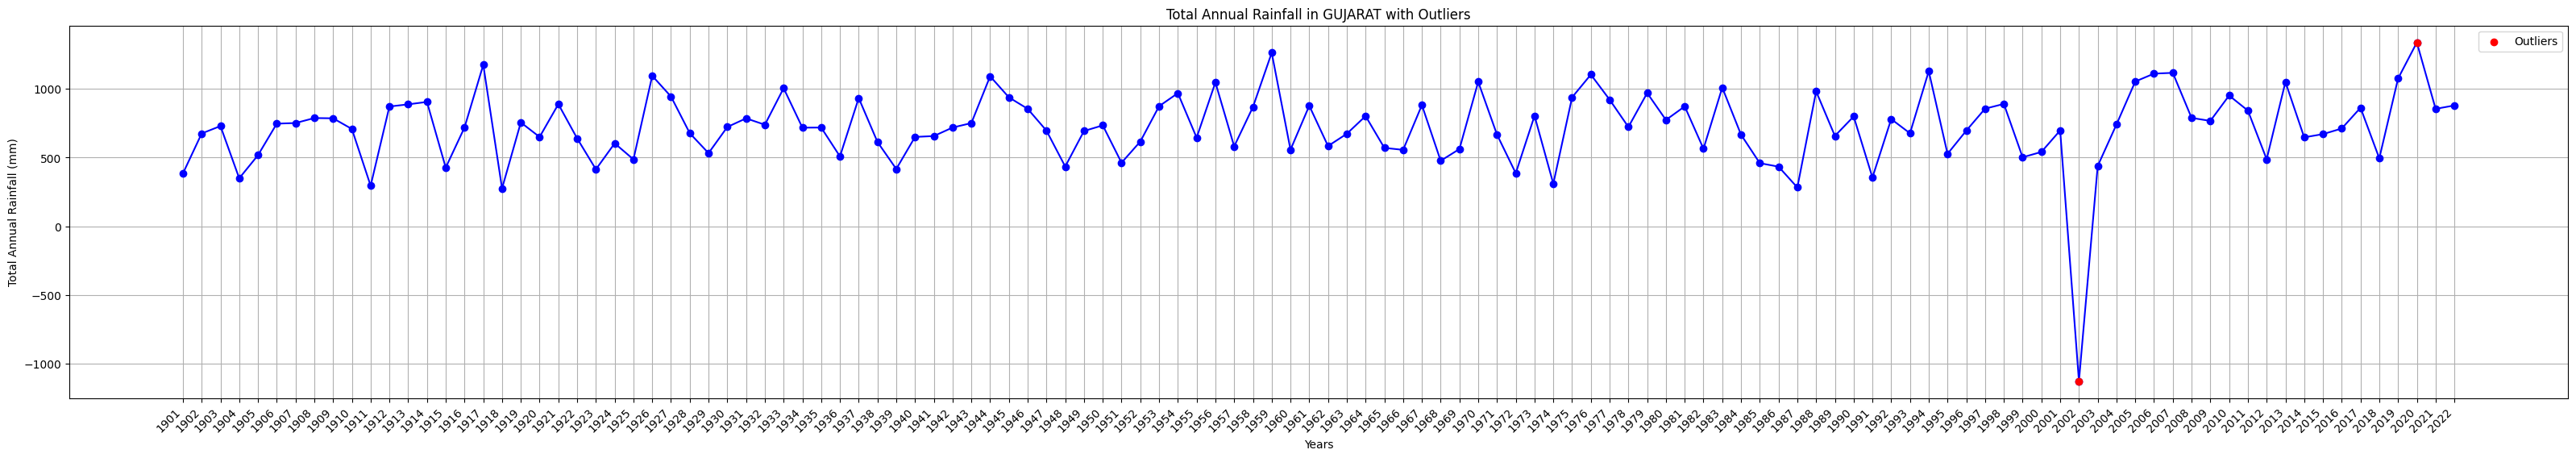

Number of Outliers: 2
Outlier Years: [2002, 2020]
Outlier Values: [-1128.2997556847454, 1338.1307052542957]


In [25]:
# Calculate the Z-scores for the 'Total Annual Rainfall' column
z_scores = zscore(result_df_pivoted['Total Annual Rainfall'])

# Define a threshold for identifying outliers (e.g., Z-score greater than 2)
outlier_threshold = 2

# Identify outlier indices
outlier_indices = np.where(np.abs(z_scores) > outlier_threshold)[0]

# Plot the line graph with outliers highlighted
plt.figure(figsize=(40, 6))
plt.plot(result_df_pivoted['Year'], result_df_pivoted['Total Annual Rainfall'], marker='o', linestyle='-', color='b')
plt.scatter(result_df_pivoted['Year'].iloc[outlier_indices], result_df_pivoted['Total Annual Rainfall'].iloc[outlier_indices], color='r', label='Outliers',  zorder=5)
plt.xlabel('Years')
plt.ylabel('Total Annual Rainfall (mm)')
plt.title('Total Annual Rainfall in GUJARAT with Outliers')
plt.xticks(np.arange(min(result_df_pivoted['Year']), max(result_df_pivoted['Year']) + 1, 1), rotation=45, ha='right')
plt.legend()
plt.grid(True)
plt.show()

# Print information about outliers
print(f"Number of Outliers: {len(outlier_indices)}")
print(f"Outlier Years: {result_df_pivoted['Year'].iloc[outlier_indices].tolist()}")
print(f"Outlier Values: {result_df_pivoted['Total Annual Rainfall'].iloc[outlier_indices].tolist()}")

AVERAGE ANNUAL RAINFALL OF GUJARAT(10 YEAR WINDOW)

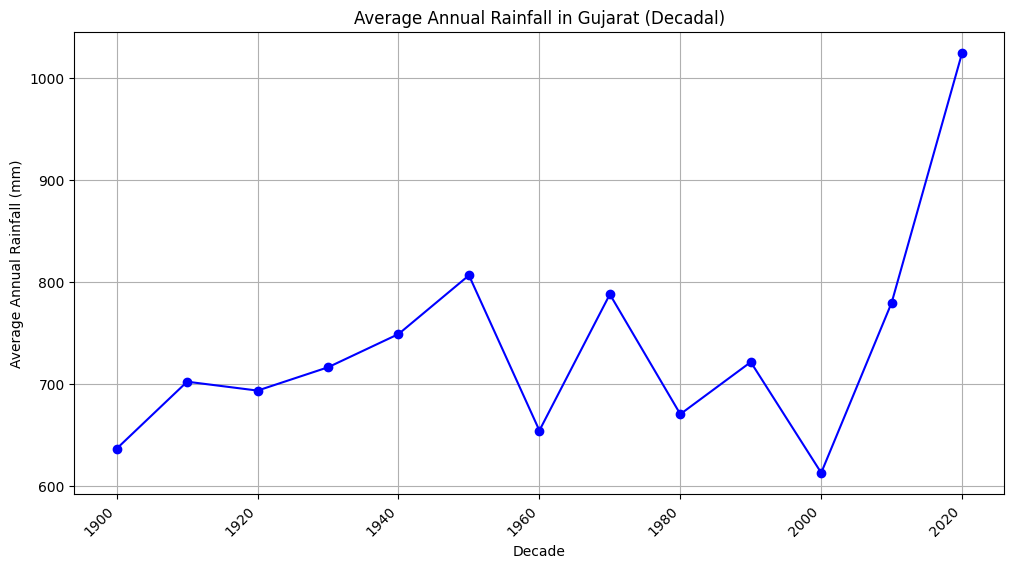

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Assuming you have a DataFrame named result_df_pivoted with columns 'Year' and 'Total Annual Rainfall'
# Adjust column names based on your actual data structure

# Calculate average annual rainfall across each 10 years
result_df_pivoted['Decade'] = (result_df_pivoted['Year'] // 10) * 10
decadal_average_rainfall = result_df_pivoted.groupby('Decade')['Total Annual Rainfall'].mean()

# Plot the decadal average annual rainfall as a line plot
plt.figure(figsize=(12, 6))
plt.plot(decadal_average_rainfall.index, decadal_average_rainfall, marker='o', color='b', linestyle='-')
plt.xlabel('Decade')
plt.ylabel('Average Annual Rainfall (mm)')
plt.title(f'Average Annual Rainfall in Gujarat (Decadal)')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()

FINDING MEAN AND STANDARD DEVIATION OF THE ABOVE CODE

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Assuming you have a DataFrame named result_df_pivoted with columns 'Year' and 'Total Annual Rainfall'
# Adjust column names based on your actual data structure

# Calculate average annual rainfall across each 10 years
result_df_pivoted['Decade'] = (result_df_pivoted['Year'] // 10) * 10
decadal_average_rainfall = result_df_pivoted.groupby('Decade')['Total Annual Rainfall'].mean()

# Print the mean and standard deviation
mean_rainfall = decadal_average_rainfall.mean()
std_rainfall = decadal_average_rainfall.std()

print(f"Mean Annual Rainfall: {mean_rainfall} mm")
print(f"Standard Deviation of Annual Rainfall: {std_rainfall} mm")







Mean Annual Rainfall: 734.9994939635076 mm
Standard Deviation of Annual Rainfall: 105.00703986411797 mm


MONTHLY RAINFALL ANALYSIS FROM 1901 TO 2022

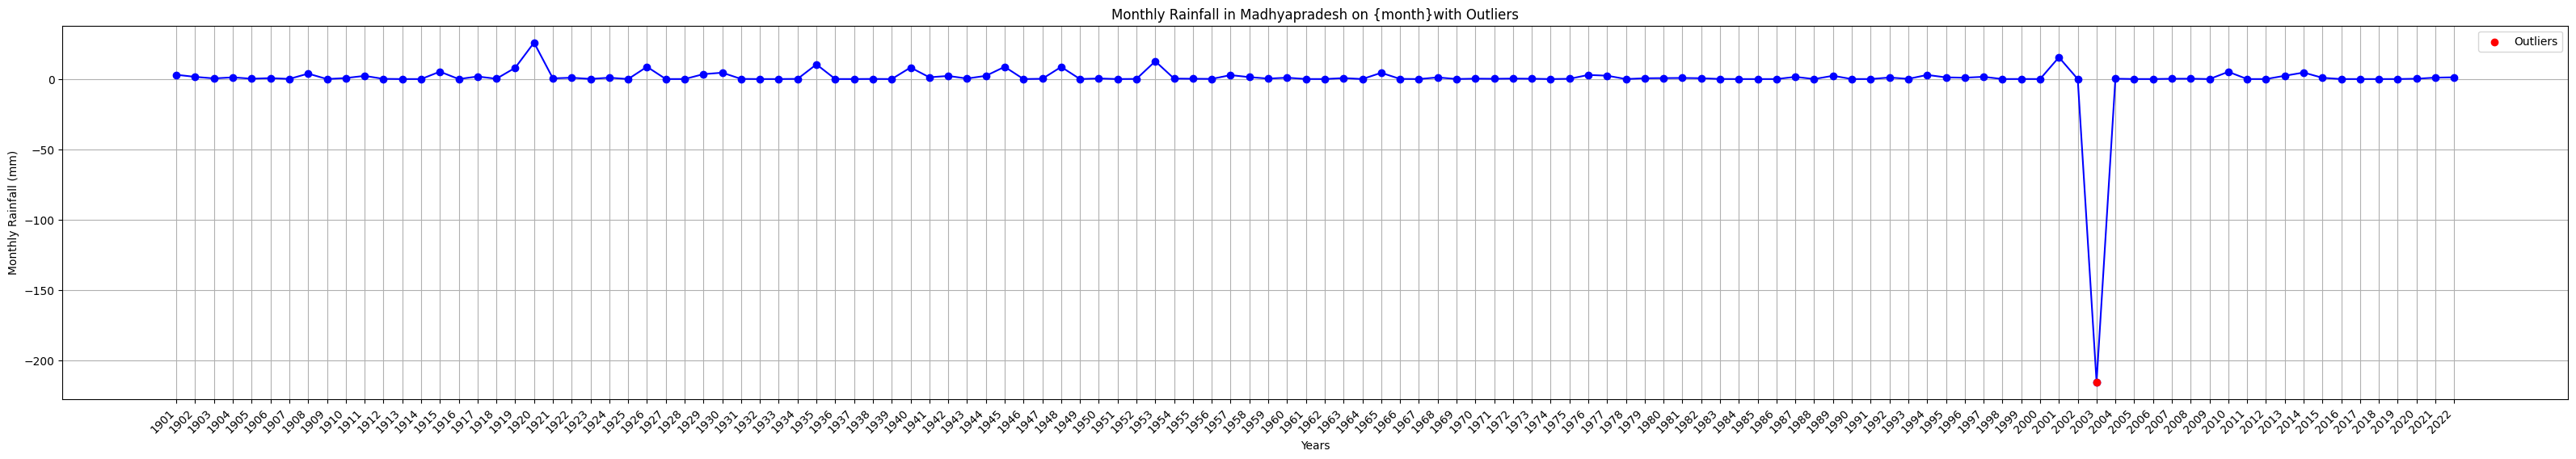

Number of Outliers: 1
Outlier Years: [2003]
Outlier Values: [-215.15169470413375]


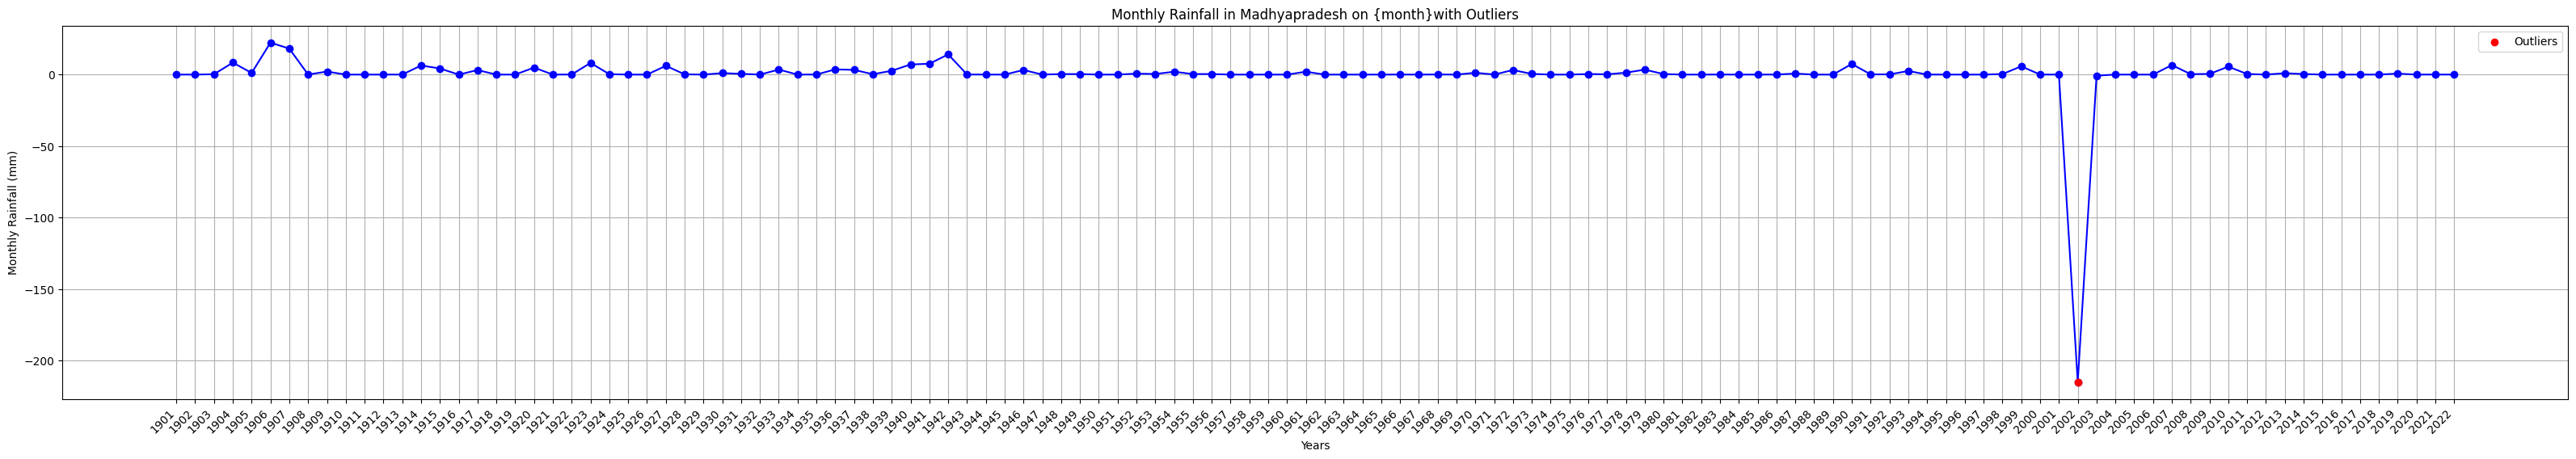

Number of Outliers: 1
Outlier Years: [2002]
Outlier Values: [-214.89310230200113]


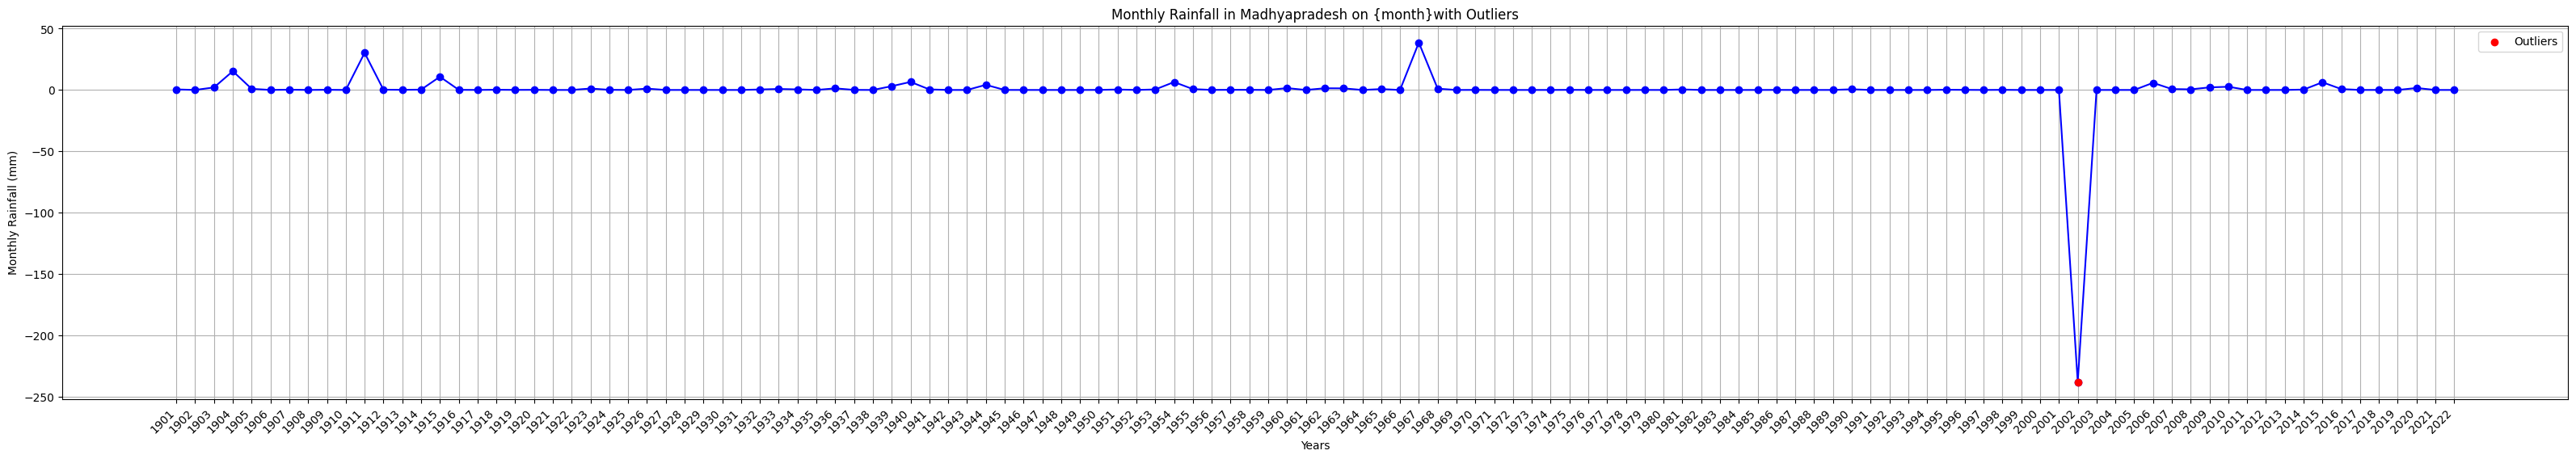

Number of Outliers: 1
Outlier Years: [2002]
Outlier Values: [-238.2230805617113]


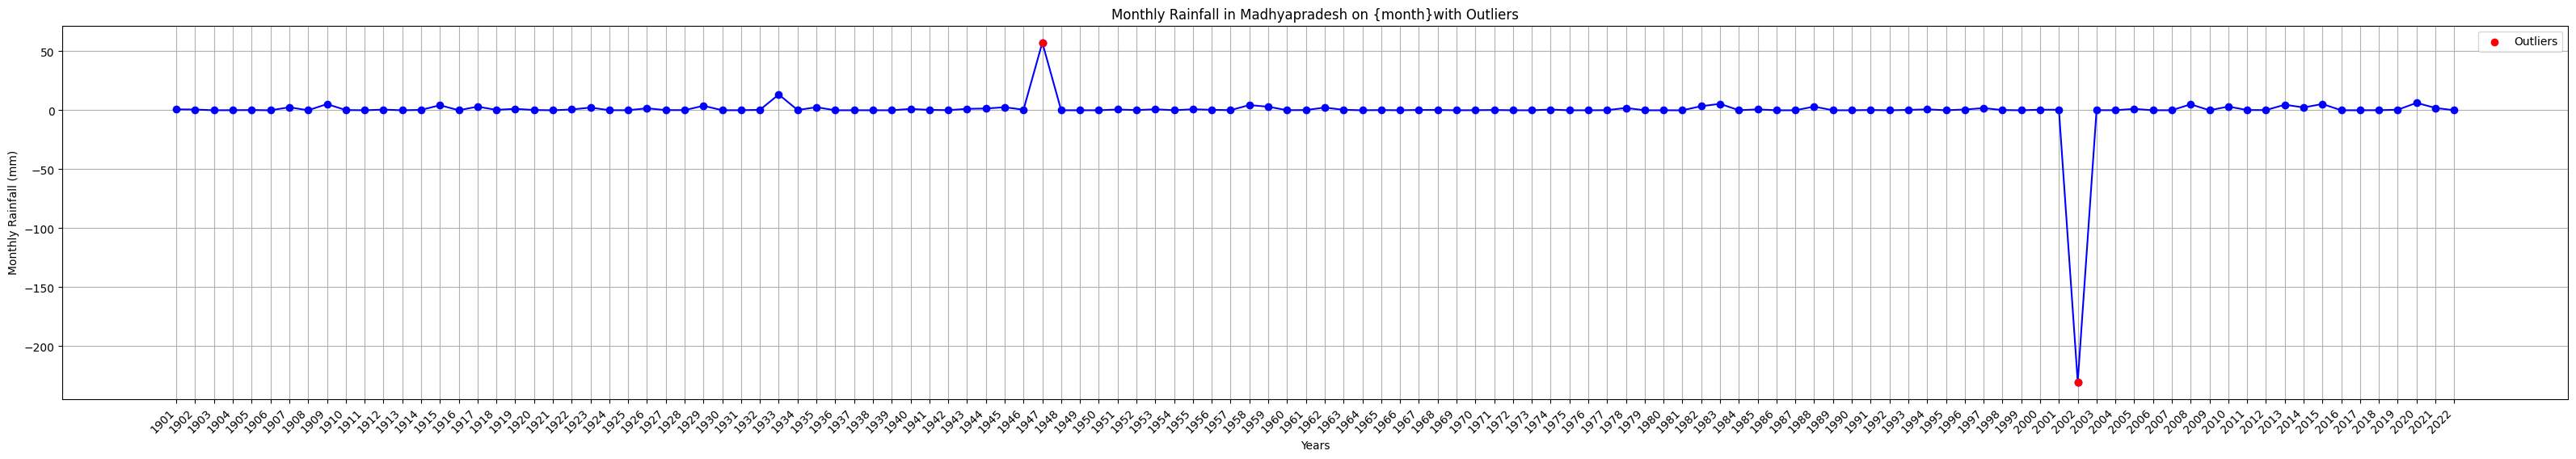

Number of Outliers: 2
Outlier Years: [1947, 2002]
Outlier Values: [57.34223946900322, -230.32880648855985]


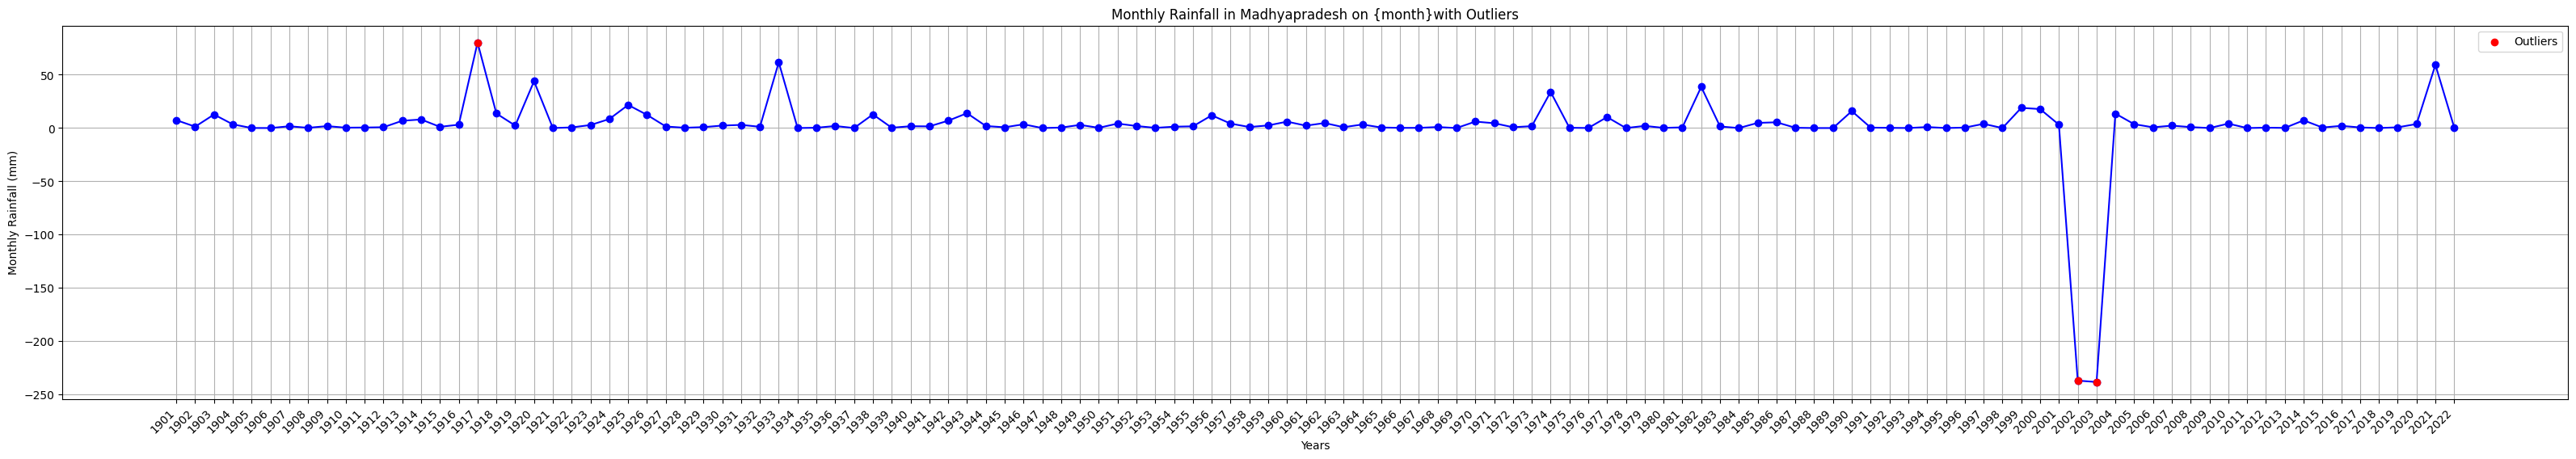

Number of Outliers: 3
Outlier Years: [1917, 2002, 2003]
Outlier Values: [80.13972233006587, -236.9101544343509, -238.2230805617113]


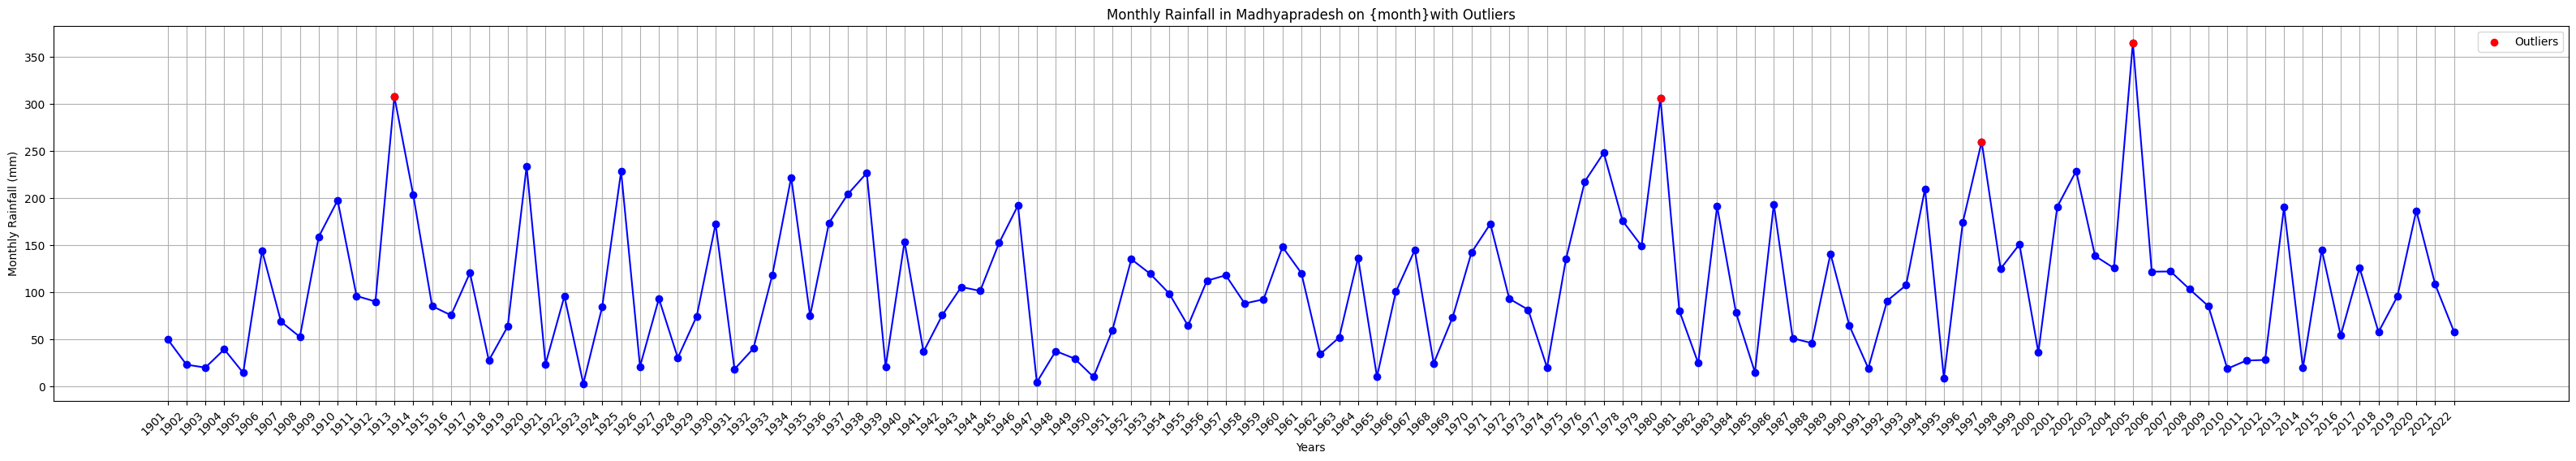

Number of Outliers: 4
Outlier Years: [1913, 1980, 1997, 2005]
Outlier Values: [307.65021920891905, 306.10414987716536, 259.69214237997164, 364.7683858561975]


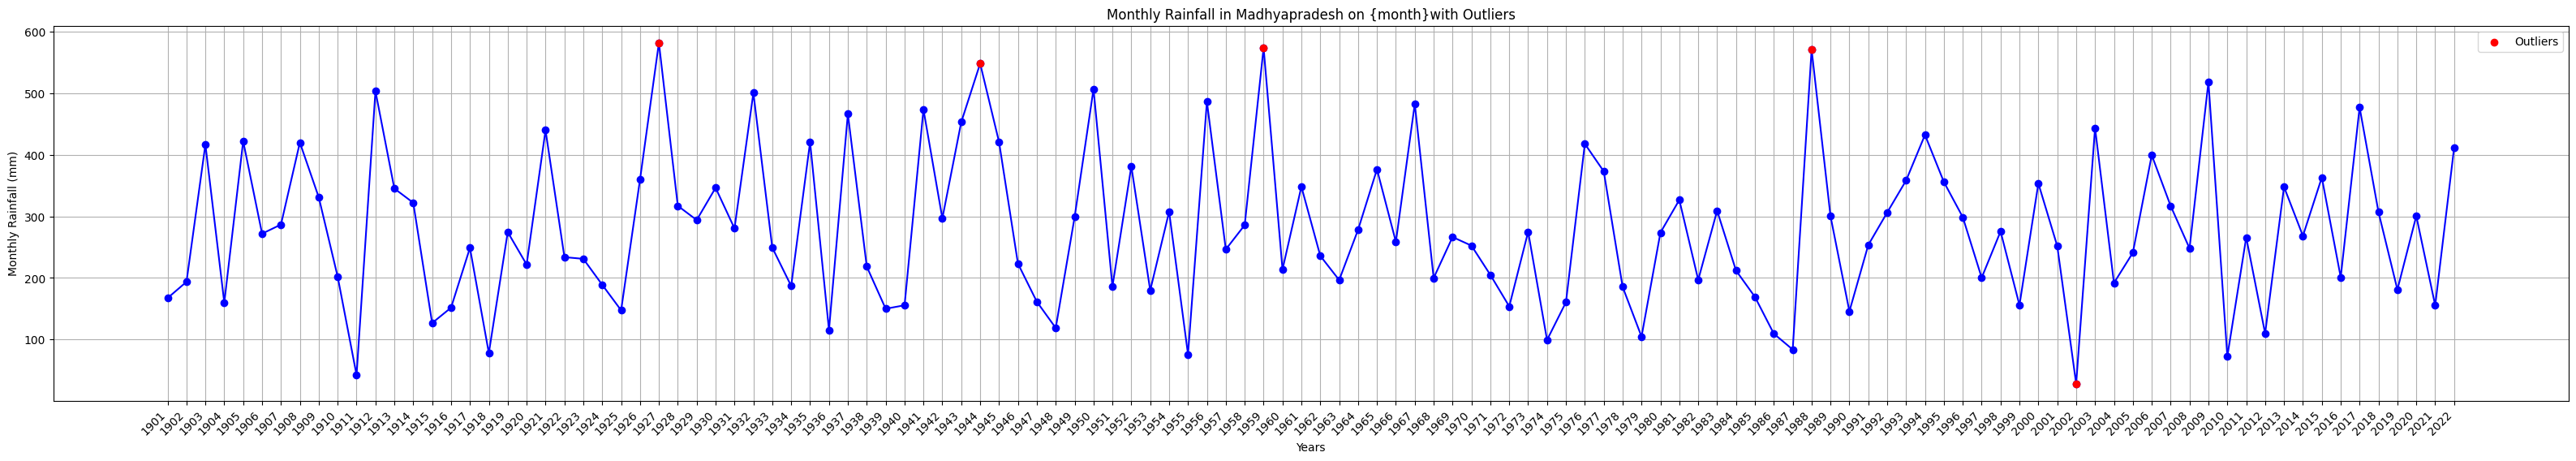

Number of Outliers: 5
Outlier Years: [1927, 1944, 1959, 1988, 2002]
Outlier Values: [582.3833031617105, 548.6557241411736, 574.3925305662247, 571.3252765401623, 27.99178449608959]


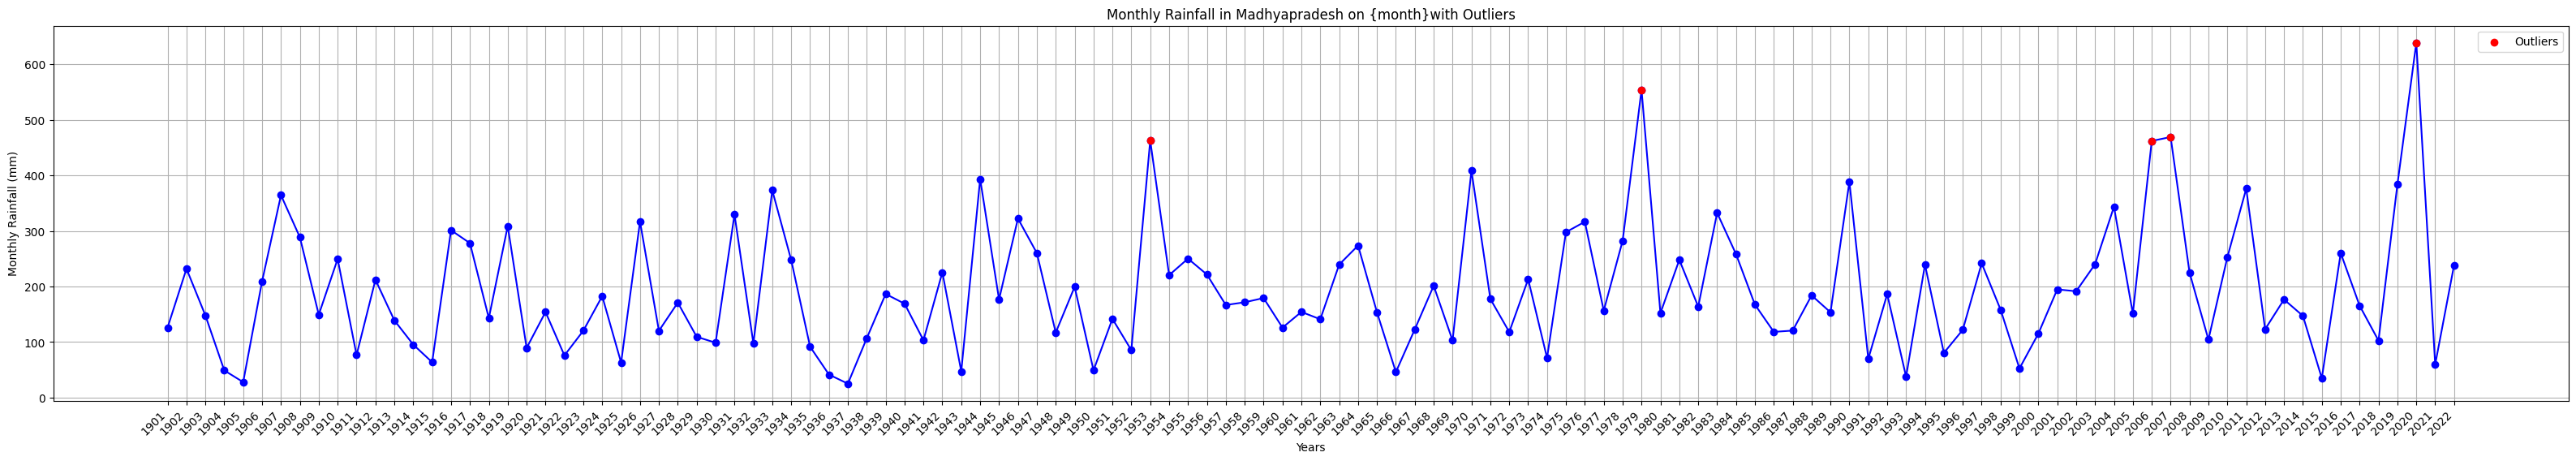

Number of Outliers: 5
Outlier Years: [1953, 1979, 2006, 2007, 2020]
Outlier Values: [463.0039227524629, 554.1846910076073, 462.1328512610724, 469.18905233763724, 638.8925728560067]


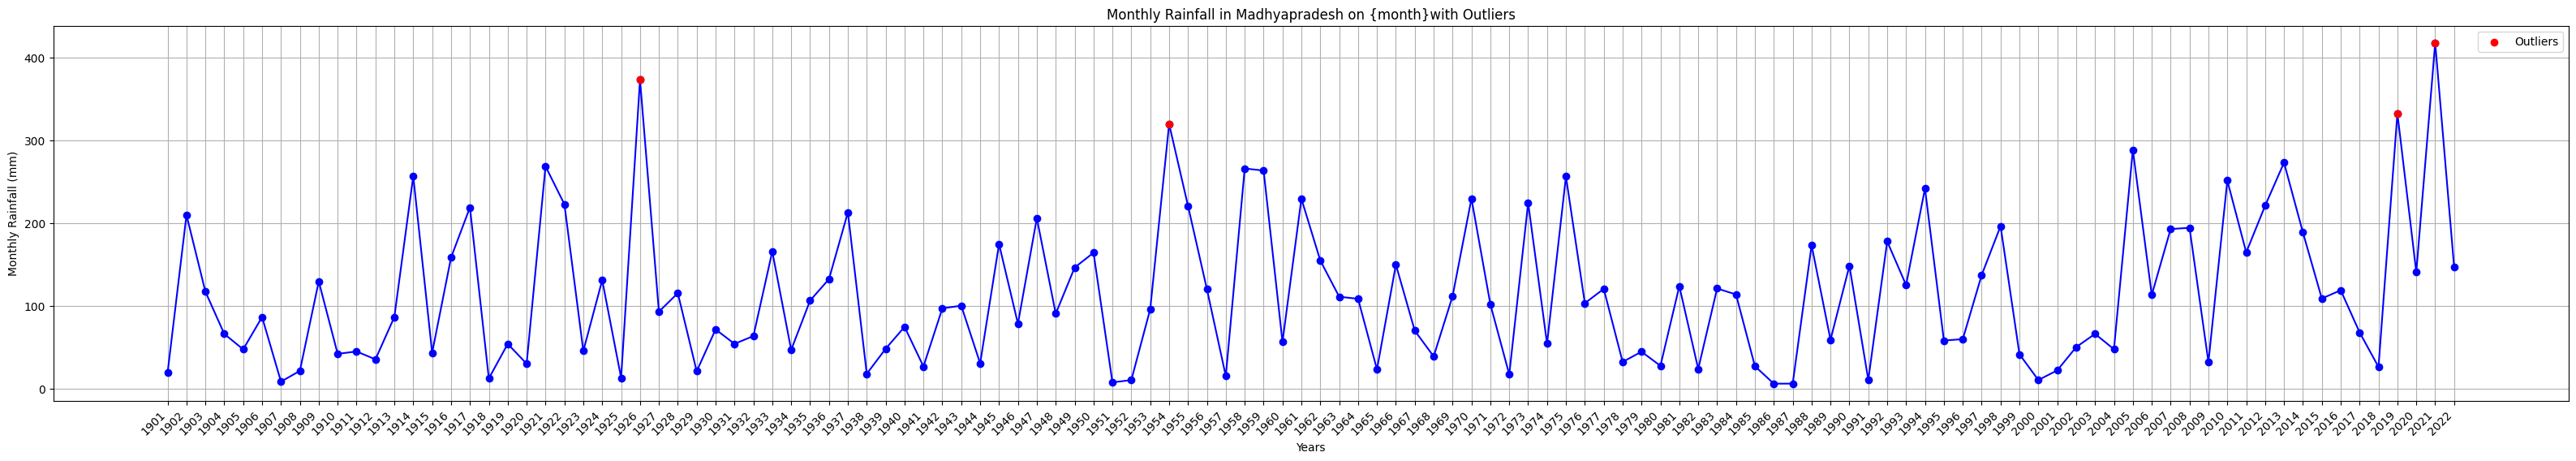

Number of Outliers: 4
Outlier Years: [1926, 1954, 2019, 2021]
Outlier Values: [373.50930090449174, 319.98767508165196, 332.8497700470572, 418.1446215791198]


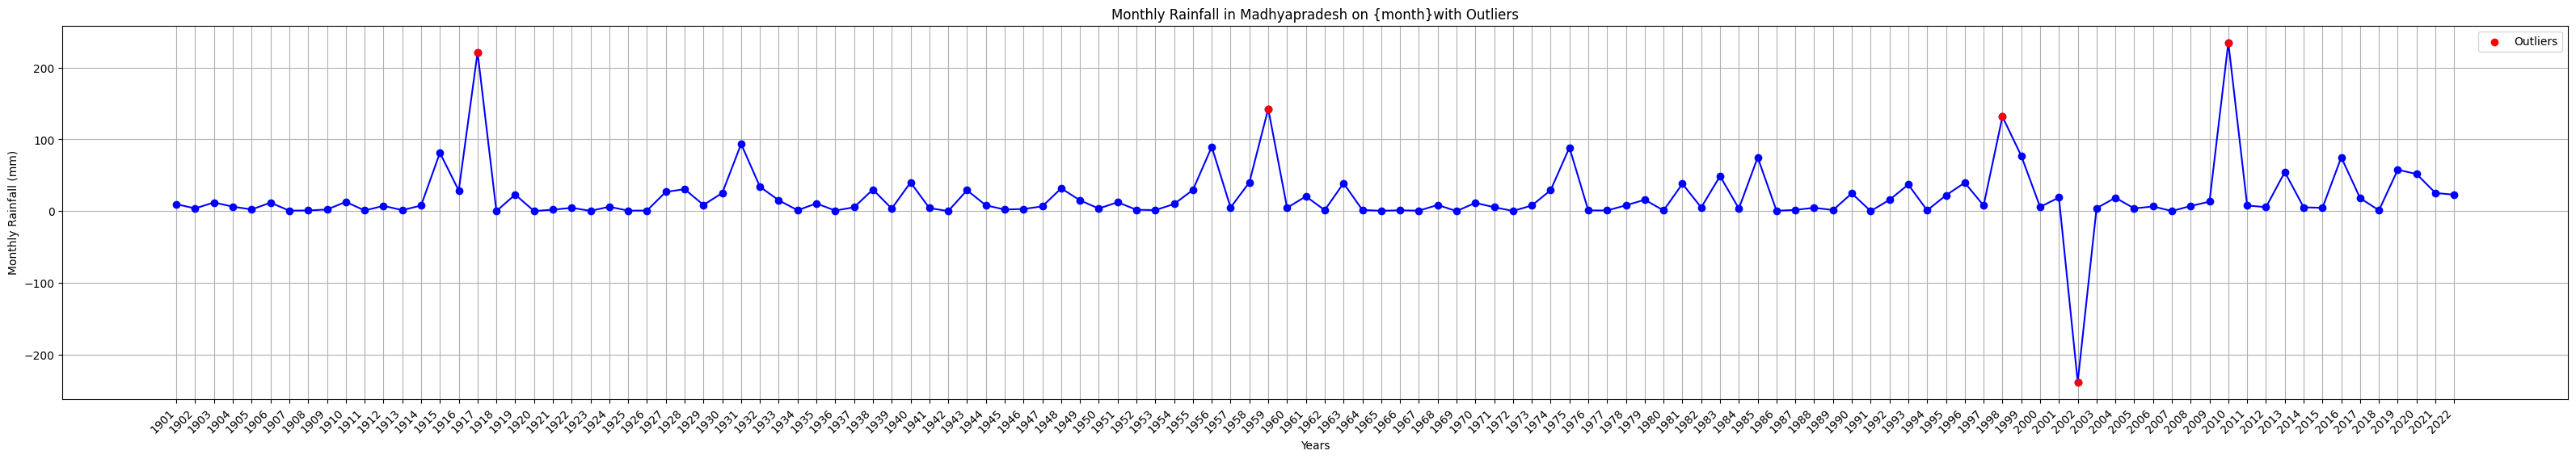

Number of Outliers: 5
Outlier Years: [1917, 1959, 1998, 2002, 2010]
Outlier Values: [221.23235797280304, 142.60368057770225, 131.61195011207693, -238.14909710333902, 234.75286104472784]


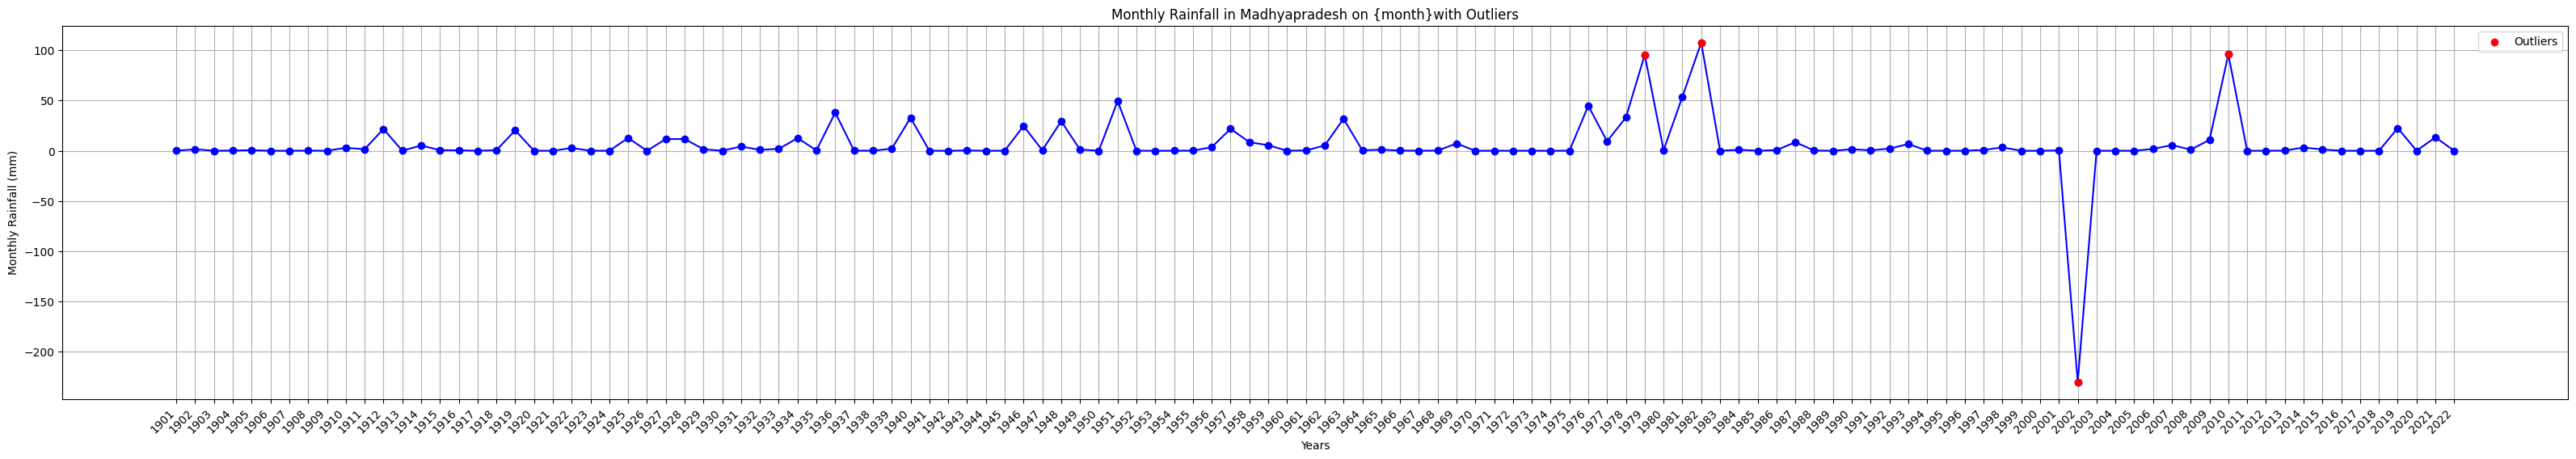

Number of Outliers: 4
Outlier Years: [1979, 1982, 2002, 2010]
Outlier Values: [95.48846134142234, 107.58353822850265, -230.0478429817237, 95.88258106433427]


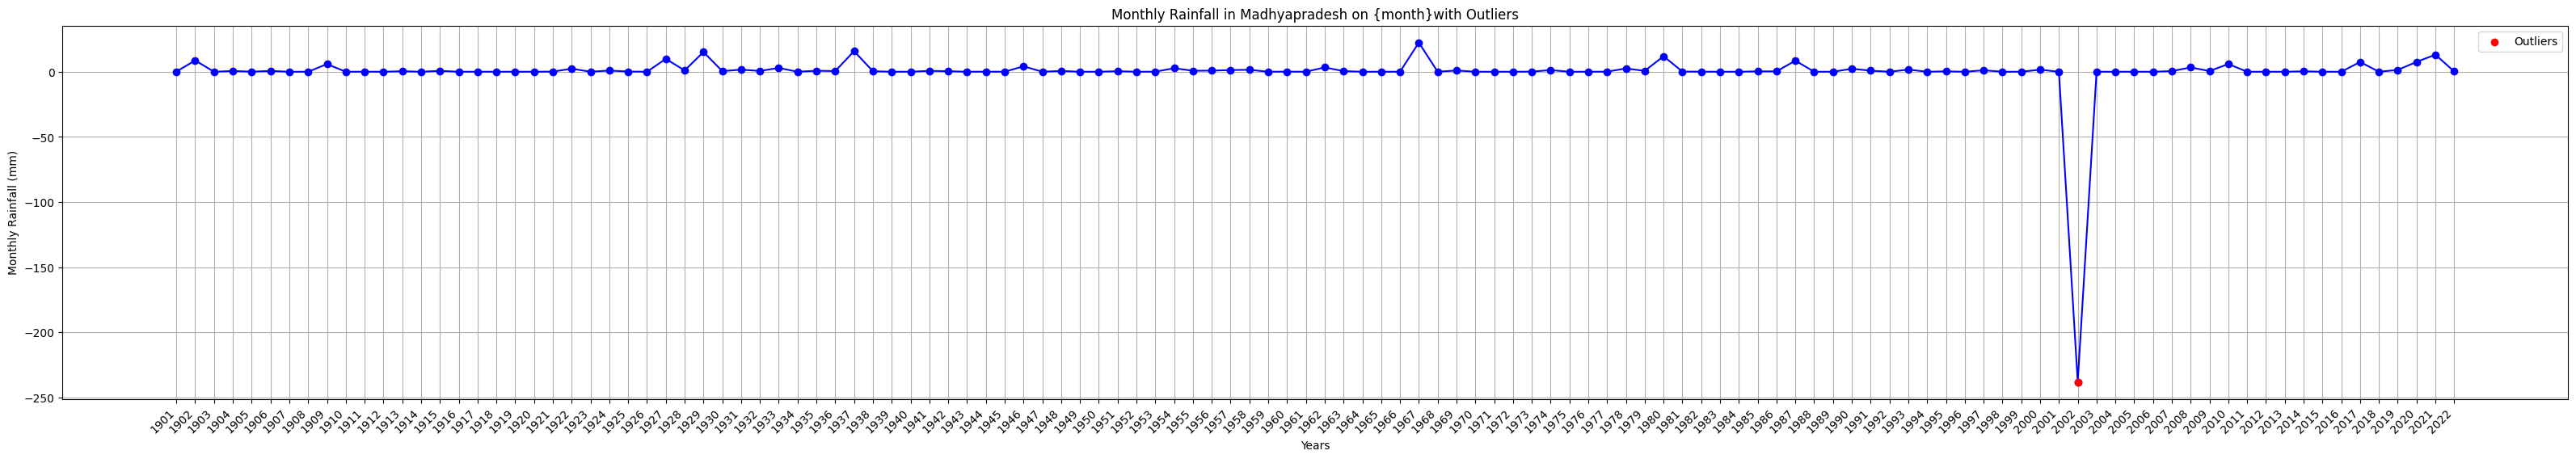

Number of Outliers: 1
Outlier Years: [2002]
Outlier Values: [-238.15160032419064]


In [28]:
for month in months:
  # Calculate the Z-scores for the 'month' column
  z_scores = zscore(result_df_pivoted[month])

  # Define a threshold for identifying outliers (e.g., Z-score greater than 2)
  outlier_threshold = 2

  # Identify outlier indices
  outlier_indices = np.where(np.abs(z_scores) > outlier_threshold)[0]

  # Plot the line graph with outliers highlighted
  plt.figure(figsize=(40, 6))
  plt.plot(result_df_pivoted['Year'], result_df_pivoted[month], marker='o', linestyle='-', color='b')
  plt.scatter(result_df_pivoted['Year'].iloc[outlier_indices], result_df_pivoted[month].iloc[outlier_indices], color='r', label='Outliers',  zorder=5)
  plt.xlabel('Years')
  plt.ylabel('Monthly Rainfall (mm)')
  plt.title('Monthly Rainfall in Madhyapradesh on {month}with Outliers')
  plt.xticks(np.arange(min(result_df_pivoted['Year']), max(result_df_pivoted['Year']) + 1, 1), rotation=45, ha='right')
  plt.legend()
  plt.grid(True)
  plt.show()

  # Print information about outliers
  print(f"Number of Outliers: {len(outlier_indices)}")
  print(f"Outlier Years: {result_df_pivoted['Year'].iloc[outlier_indices].tolist()}")
  print(f"Outlier Values: {result_df_pivoted[month].iloc[outlier_indices].tolist()}")

TOTAL ANNUAL RAINFALL ANALYSIS FROM 1901 TO 2022

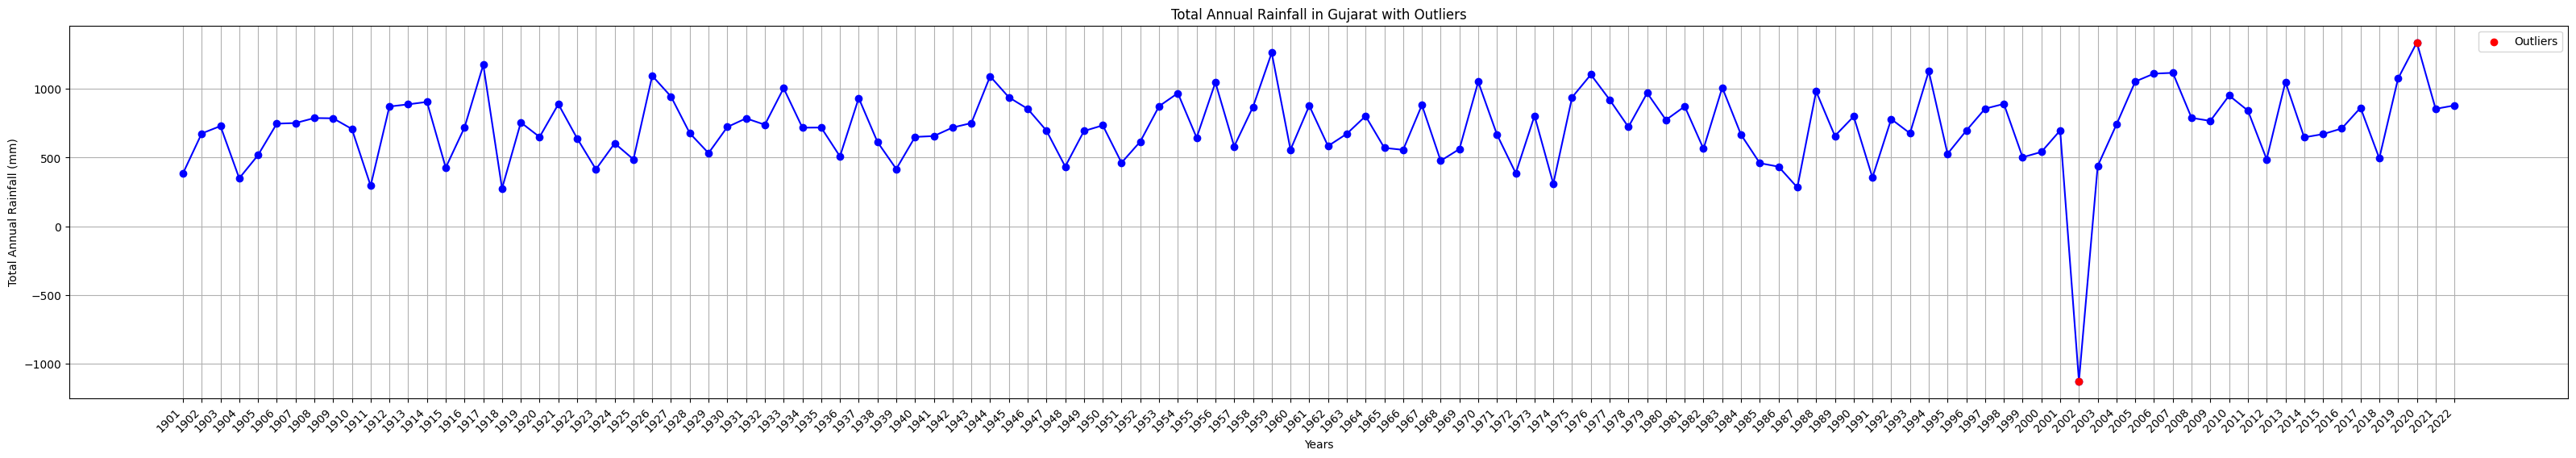

Number of Outliers: 2
Outlier Years: [2002, 2020]
Outlier Values: [-1128.2997556847454, 1338.1307052542957]


In [29]:
# Calculate the Z-scores for the 'Total Annual Rainfall' column
z_scores = zscore(result_df_pivoted['Total Annual Rainfall'])

# Define a threshold for identifying outliers (e.g., Z-score greater than 2)
outlier_threshold = 2

# Identify outlier indices
outlier_indices = np.where(np.abs(z_scores) > outlier_threshold)[0]

# Plot the line graph with outliers highlighted
plt.figure(figsize=(40, 6))
plt.plot(result_df_pivoted['Year'], result_df_pivoted['Total Annual Rainfall'], marker='o', linestyle='-', color='b')
plt.scatter(result_df_pivoted['Year'].iloc[outlier_indices], result_df_pivoted['Total Annual Rainfall'].iloc[outlier_indices], color='r', label='Outliers',  zorder=5)
plt.xlabel('Years')
plt.ylabel('Total Annual Rainfall (mm)')
plt.title('Total Annual Rainfall in Gujarat with Outliers')
plt.xticks(np.arange(min(result_df_pivoted['Year']), max(result_df_pivoted['Year']) + 1, 1), rotation=45, ha='right')
plt.legend()
plt.grid(True)
plt.show()

# Print information about outliers
print(f"Number of Outliers: {len(outlier_indices)}")
print(f"Outlier Years: {result_df_pivoted['Year'].iloc[outlier_indices].tolist()}")
print(f"Outlier Values: {result_df_pivoted['Total Annual Rainfall'].iloc[outlier_indices].tolist()}")

YEARS WITH AVERAGE RAINFALL ABOVE 95 PERCENTILE AND BELOW 5 PERCENTILE

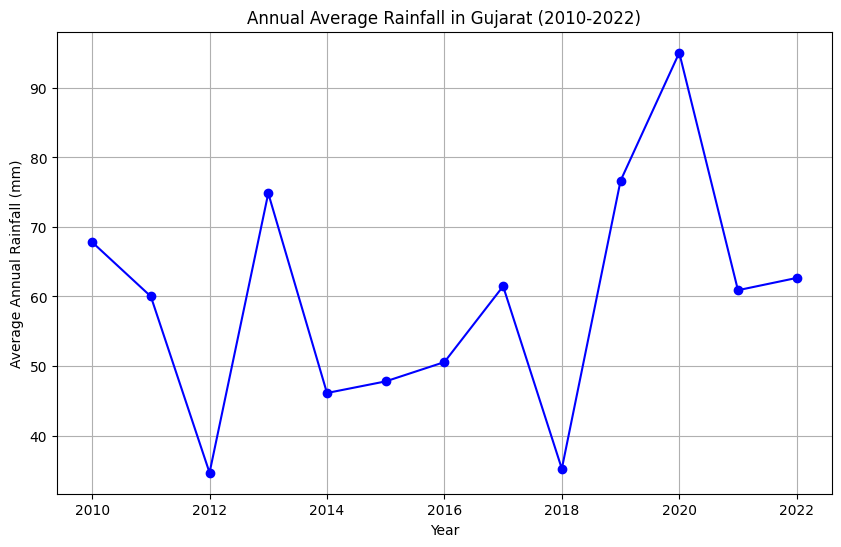

Years above 95th percentile: [2020]
Years below 5th percentile: [2012]


In [31]:
# Initialize an empty list to store annual average rainfall
annual_averages = []

# Loop through each year in the specified range (2010 to 2022)
for year in range(2010, 2023):
    # Load the rainfall data for the current year
    rainfall_data = xr.open_dataset(data_path + f'{year}.nc')

    # Find latitude and longitude indices within Gujarat's boundaries
    latitude_indices = np.where((rainfall_data['LATITUDE'] >= min_latitude) & (rainfall_data['LATITUDE'] <= max_latitude))[0]
    longitude_indices = np.where((rainfall_data['LONGITUDE'] >= min_longitude) & (rainfall_data['LONGITUDE'] <= max_longitude))[0]

    # Slice the rainfall data for Gujarat
    gujarat_rainfall_data = rainfall_data['RAINFALL'][:, latitude_indices, longitude_indices]

    # Calculate the annual average rainfall
    annual_average_rainfall = gujarat_rainfall_data.mean(dim='TIME').sum().item()
    annual_averages.append(annual_average_rainfall)

    # Close the NetCDF dataset to free up resources
    rainfall_data.close()

# Plot the annual average rainfall
plt.figure(figsize=(10, 6))
plt.plot(range(2010, 2023), annual_averages, marker='o', linestyle='-', color='b')
plt.xlabel('Year')
plt.ylabel('Average Annual Rainfall (mm)')
plt.title('Annual Average Rainfall in Gujarat (2010-2022)')
plt.grid(True)
plt.show()

# Calculate percentiles
percentile_5 = np.percentile(annual_averages, 5)
percentile_95 = np.percentile(annual_averages, 95)

# Print years above 95th percentile
above_95 = [year for year, avg in zip(range(2010, 2023), annual_averages) if avg > percentile_95]
print(f'Years above 95th percentile: {above_95}')

# Print years below 5th percentile
below_5 = [year for year, avg in zip(range(2010, 2023), annual_averages) if avg < percentile_5]
print(f'Years below 5th percentile: {below_5}')

MANN-KENDALL TEST AND SEN SLOPE ESTIMATOR FOR TREND ANALYSIS.
##### Mann-Kendall test : A non-parametric statistical test used to assess the presence of trends in time series data by evaluating the monotonicity of the data over time.

##### Sen Slope Estimator : A method for estimating the slope of a trend in time series data

In [32]:
# Filter the DataFrame for the desired years (2022 to 2012)
print("Enter the range of years(year1 to year2)")
year1 = int(input())
year2 = int(input())
selected_years = range(year1, year2 + 1)
df_selected_years = result_df_pivoted[result_df_pivoted['Year'].isin(selected_years)]

result, _ = kendalltau(df_selected_years['Year'],df_selected_years['Total Annual Rainfall'])

# Calculate p-value for the Mann-Kendall test
p_value = 2 * norm.cdf(-abs(result))

result_s = linregress(df_selected_years['Year'], df_selected_years['Total Annual Rainfall'])

# Display Mann-Kendall test result
print(f"Mann-Kendall Test Result for Yearly Sum of Rainfall ({year1} to {year2}):")
#print(f"Kendall's Tau: {result}")
print(f"P-value: {p_value}")

# Display Theil-Sen estimator result
print(f"Theil-Sen Estimator Result for Yearly Sum of Rainfall ({year1} to {year2}):")
print(f"Slope (Sen's Slope): {result_s.slope}")

if p_value < 0.05:
    if result_s.slope > 0:
        print("Significant positive trend")
    elif result_s.scope < 0:
        print("Significant negative trend")
    else:
        print("No significant trend")
else:
    print("No significant trend")

Enter the range of years(year1 to year2)
2020
2022
Mann-Kendall Test Result for Yearly Sum of Rainfall (2020 to 2022):
P-value: 0.7388826803635272
Theil-Sen Estimator Result for Yearly Sum of Rainfall (2020 to 2022):
Slope (Sen's Slope): -229.1796947398151
No significant trend


In [33]:
# Filter the DataFrame for the desired years (2022 to 2012)
print("Enter the range of years(year1 to year2)")
year1 = int(input())
year2 = int(input())
selected_years = range(year1, year2 + 1)
df_selected_years = result_df_pivoted[result_df_pivoted['Year'].isin(selected_years)]

result, _ = kendalltau(df_selected_years['Year'],df_selected_years['Jan'])

# Calculate p-value for the Mann-Kendall test
p_value = 2 * norm.cdf(-abs(result))

result_s = linregress(df_selected_years['Year'], df_selected_years['Jan'])

# Display Mann-Kendall test result
print(f"Mann-Kendall Test Result for Monthly Rainfall of January ({year1} to {year2}):")
#print(f"Kendall's Tau: {result}")
print(f"P-value: {p_value}")

# Display Theil-Sen estimator result
print(f"Theil-Sen Estimator Result for Monthly Rainfall of January ({year1} to {year2}):")
print(f"Slope (Sen's Slope): {result_s.slope}")

if p_value < 0.05:
    if result_s.slope > 0:
        print("Significant positive trend")
    elif result_s.scope < 0:
        print("Significant negative trend")
    else:
        print("No significant trend")
else:
    print("No significant trend")

Enter the range of years(year1 to year2)
2020
2022
Mann-Kendall Test Result for Monthly Rainfall of January (2020 to 2022):
P-value: 0.31731050786291415
Theil-Sen Estimator Result for Monthly Rainfall of January (2020 to 2022):
Slope (Sen's Slope): 0.507864996790886
No significant trend


PETTITT TEST
##### A non-parametric statistical test used to detect a change point or discontinuity in a time series, indicating a significant shift in the distribution of the data.

In [34]:
# Filter the DataFrame for the desired years (2022 to 2012)
print("Enter the range of years (year1 to year2)")
year1 = int(input())
year2 = int(input())
selected_years = range(year1, year2 + 1)
df_selected_years = result_df_pivoted[result_df_pivoted['Year'].isin(selected_years)]

# Perform Pettitt test for the selected years
result_pettitt = hg.pettitt_test(df_selected_years['Total Annual Rainfall'])

# Display Pettitt test result
print(f"Pettitt Test Result for Yearly Sum of Rainfall ({year1} to {year2}):")
print(f"Change detected: {result_pettitt.h}")
print(f"Change point index: {result_pettitt.cp}")
print(f"P-value: {result_pettitt.p}")
print(f"Test Statistic (U): {result_pettitt.U}")
print(f"Mean Before Change (mu1): {result_pettitt.avg.mu1}")
print(f"Mean After Change (mu2): {result_pettitt.avg.mu2}")

Enter the range of years (year1 to year2)
2020
2022
Pettitt Test Result for Yearly Sum of Rainfall (2020 to 2022):
Change detected: True
Change point index: 1
P-value: 0.0
Test Statistic (U): 2.0
Mean Before Change (mu1): 1338.1307052542957
Mean After Change (mu2): 867.3802488553697


In [35]:
# Filter the DataFrame for the desired years (2022 to 2012)
print("Enter the range of years (year1 to year2)")
year1 = int(input())
year2 = int(input())
selected_years = range(year1, year2 + 1)
df_selected_years = result_df_pivoted[result_df_pivoted['Year'].isin(selected_years)]

# Perform Pettitt test for the selected years
result_pettitt = hg.pettitt_test(df_selected_years['Jan'])

# Display Pettitt test result
print(f"Pettitt Test Result for Monthly Rainfall of January ({year1} to {year2}):")
print(f"Change detected: {result_pettitt.h}")
print(f"Change point index: {result_pettitt.cp}")
print(f"P-value: {result_pettitt.p}")
print(f"Test Statistic (U): {result_pettitt.U}")
print(f"Mean Before Change (mu1): {result_pettitt.avg.mu1}")
print(f"Mean After Change (mu2): {result_pettitt.avg.mu2}")

Enter the range of years (year1 to year2)
2020
2022
Pettitt Test Result for Monthly Rainfall of January (2020 to 2022):
Change detected: True
Change point index: 1
P-value: 0.0
Test Statistic (U): 2.0
Mean Before Change (mu1): 0.2271563708782196
Mean After Change (mu2): 1.122993727429555
